In [105]:
#split data into 20 categories (10-90% percentile for positive and negative so 10x2) based on SMA 1 minute from past 20 days, 
#then within each SMA category, separate into quartiles based on cumulative volume in 1 minute
#calculate the mean and std of the edge in each case

import pandas as pd
import datetime
import numpy as np
from tqdm import tqdm_notebook
from datetime import datetime,timedelta
import os
from timeit import default_timer as timer
from scipy import stats
from sklearn import linear_model
import matplotlib.pyplot as plt

path='/Users/hudsonyeo/Desktop/Python/leo/data/day/TA'
os.chdir('/Users/hudsonyeo/Desktop/Python/leo/data/day/TA')
file_list=os.listdir(path)
file_list.sort()

In [106]:
file_list

['.DS_Store',
 '2019.01.02.csv',
 '2019.01.03.csv',
 '2019.01.04.csv',
 '2019.01.07.csv',
 '2019.01.08.csv',
 '2019.01.09.csv',
 '2019.01.10.csv',
 '2019.01.11.csv',
 '2019.01.14.csv',
 '2019.01.15.csv',
 '2019.01.16.csv',
 '2019.01.17.csv',
 '2019.01.18.csv',
 '2019.01.21.csv',
 '2019.01.22.csv',
 '2019.01.23.csv',
 '2019.01.24.csv',
 '2019.01.25.csv',
 '2019.01.28.csv',
 '2019.01.29.csv',
 '2019.01.30.csv',
 '2019.01.31.csv',
 '2019.02.01.csv',
 '2019.02.11.csv',
 '2019.02.12.csv',
 '2019.02.13.csv',
 '2019.02.14.csv',
 '2019.02.15.csv',
 '2019.02.18.csv',
 '2019.02.19.csv',
 '2019.02.20.csv',
 '2019.02.21.csv',
 '2019.02.22.csv',
 '2019.02.25.csv',
 '2019.02.26.csv',
 '2019.02.27.csv',
 '2019.02.28.csv',
 '2019.03.01.csv',
 '2019.03.04.csv',
 '2019.03.05.csv',
 '2019.03.06.csv',
 '2019.03.07.csv',
 '2019.03.08.csv',
 '2019.03.11.csv',
 '2019.03.12.csv',
 '2019.03.13.csv',
 '2019.03.14.csv',
 '2019.03.15.csv',
 '2019.03.18.csv',
 '2019.03.19.csv',
 '2019.03.20.csv',
 '2019.03.21.csv'

In [107]:
class categorise():
    def __init__(self):
        self.threshold=[]
        self.percentiles=[25,50,75]
        
    def fit(self,array):
        positive=array[array>0]
        negative=array[array<0]
        self.threshold.append(np.percentile(negative,self.percentiles))   
        self.threshold.append(np.percentile(positive,self.percentiles))
     
    def return_quartile(self,array):
        temp=[]
        for i in array:
            if i>=0:
                if i<self.threshold[1][0]:
                    temp.append(5)
                elif i<self.threshold[1][1]:
                    temp.append(6)
                elif i<self.threshold[1][2]:
                    temp.append(7)
                else:
                    temp.append(8)
            if i<0:
                if i>self.threshold[0][2]:
                    temp.append(4)
                elif i>self.threshold[0][1]:
                    temp.append(3)
                elif i>self.threshold[0][0]:
                    temp.append(2)
                else:
                    temp.append(1)
        return np.asarray(temp)
    
class categorise_simple():
    def __init__(self):
        self.threshold=[]
        self.percentiles=[25,50,75]
        
    def fit(self,array):
        self.threshold.append(np.percentile(array,self.percentiles))
     
    def return_quartile(self,array):
        temp=[]
        for i in array:
                if i<self.threshold[0][0]:
                    temp.append(1)
                elif i<self.threshold[0][1]:
                    temp.append(2)
                elif i<self.threshold[0][2]:
                    temp.append(3)
                else:
                    temp.append(4)
        return np.asarray(temp)    
    
class categorise_10():
    def __init__(self):
        self.threshold=[]
        self.percentiles=[10,20,30,40,50,60,70,80,90]
        
    def fit(self,array):
        positive=array[array>0]
        negative=array[array<0]
        self.threshold.append(np.percentile(negative,self.percentiles))   
        self.threshold.append(np.percentile(positive,self.percentiles))
     
    def return_quartile(self,array):
        temp=[]
        for i in array:
            if i>=0:
                if i<self.threshold[1][0]:
                    temp.append(11)
                elif i<self.threshold[1][1]:
                    temp.append(12)
                elif i<self.threshold[1][2]:
                    temp.append(13)
                elif i<self.threshold[1][3]:
                    temp.append(14)
                elif i<self.threshold[1][4]:
                    temp.append(15)
                elif i<self.threshold[1][5]:
                    temp.append(16)
                elif i<self.threshold[1][6]:
                    temp.append(17)
                elif i<self.threshold[1][7]:
                    temp.append(18)
                elif i<self.threshold[1][8]:
                    temp.append(19)                    
                else:
                    temp.append(20)
            if i<0:
                if i<self.threshold[0][0]:
                    temp.append(1)
                elif i<self.threshold[0][1]:
                    temp.append(2)
                elif i<self.threshold[0][2]:
                    temp.append(3)
                elif i<self.threshold[0][3]:
                    temp.append(4)
                elif i<self.threshold[0][4]:
                    temp.append(5)
                elif i<self.threshold[0][5]:
                    temp.append(6)
                elif i<self.threshold[0][6]:
                    temp.append(7)
                elif i<self.threshold[0][7]:
                    temp.append(8)
                elif i<self.threshold[0][8]:
                    temp.append(9)                    
                else:
                    temp.append(10)
        return np.asarray(temp)    
class cross():
    def __init__(self):
        self.time_last_cross=0
        self.current_sign=True
        self.last_time=datetime(1900, 1, 1, 8, 59)
    def get_time(self,time,price):
        if (time-self.last_time)>timedelta(minutes=1):
            self.last_time=time
            self.time_last_cross=time
            return 0
        self.last_time=time
        if (price>0) and self.current_sign : #if price positive and current trend is also positive
            return (time-self.time_last_cross).total_seconds()
        elif (price<0) and (not self.current_sign): #if price negative and current trend is negative
            return (time-self.time_last_cross).total_seconds()
        else: #if price positive, trend negative or price negative, trend positive
            self.time_last_cross=time
            self.current_sign=(price>0)
            return 0

In [108]:
def calc_smart_price(dataset):
    data=dataset[:]
    
    #to combat the limit up event, where price is set to 0. 
    rows=(data.loc[:,'BidPrice1']==0) #count rows of bid price equal 0
    if (np.any(rows)): #if there is such a row
        data.at[rows,'BidPrice1']=data.loc[rows,'AskPrice1'] #for that row, assign ask price to it
    rows=(data.loc[:,'AskPrice1']==0) #do the same for ask price
    if (np.any(rows)):
        data.at[rows,'AskPrice1']=data.loc[rows,'BidPrice1'] 
        
    data['smart_price']=data.loc[:,'BidPrice1']*data.loc[:,'AskVol1']+data.loc[:,'AskPrice1']*data.loc[:,'BidVol1']
    data.at[:,'smart_price']=data.loc[:,'smart_price']/(data.loc[:,['BidVol1','AskVol1']].sum(axis=1))  
    return data

def calc_present_vol(dataset):
    data=dataset[:]
    data['current_vol']=data.loc[:,'Volume'].diff().fillna(0)/2
    return data

def calc_future_price(dataset,time_ahead=30,time_index=44, price_col=-2):
    data=dataset[:]
    future_price=[]
    length=len(data)
    for i in range(len(data)):
        current_time=data[i,time_index]+timedelta(seconds=time_ahead)
        #print(data[i,44])
        j=0
        #print(current_time)
        while((i+j)<length and current_time>data[(i+j),time_index]):
            j+=1
        if (i+j)<length:
            future_price.append(data[(i+j),price_col]) 
        else:
            future_price.append(np.nan)
    future_price=np.asarray(future_price)
    future_price=np.expand_dims(future_price,axis=1)
    return np.concatenate((data,future_price),axis=1)


def calc_edge(dataset,future_col=-1,current_col=-3):
    data=dataset.copy()
    temp=data[:,future_col]-data[:,current_col]
    temp=np.expand_dims(temp,axis=1)
    return np.concatenate((data,temp),axis=1)

def set_index(dataset,time_index=44):
    data=dataset[:]
    index=data[:,time_index]
    new_index=[]
    for j in range(len(index)):
        i=str(index[j]*1000)
        if len(i)==11:
            i='0'+i
        i=i[:-10]+':'+i[-10:]
        i=i[:-8]+':'+i[-8:]
        i=i[:-6]+':'+i[-6:]
        new_index.append(datetime.strptime(i,"%H:%M:%S:%f"))
    data[:,time_index]=new_index
    return data

def calc_sma_fast(dataset,duration=1,time_index=44,price_col=-4): #faster way to calculate SMA, 0.05 seconds for 5000 rows
    data=dataset[:]
    sma_values=[] 
    smart_sum=np.cumsum(data[:,price_col]) #smart price column is -4
    for i in range(len(data)):
        last_time=data[i,time_index]-timedelta(minutes=duration)
        j=220*duration#4x60=240
        while(i-j>0 and data[i-j,time_index]>last_time):
            j+=1
        if (i-j>=0):
            sma=(smart_sum[i]-smart_sum[i-j])/(j)
            sma_values.append(sma)
        else:
            sma=smart_sum[i]/(i+1)
            sma_values.append(sma)

    sma_values=np.asarray(sma_values)
    sma_values=data[:,price_col]-sma_values
    sma_values=np.expand_dims(sma_values,axis=1)
    return np.concatenate((data,sma_values),axis=1)  

def calc_past_vol(dataset,duration=1,time_index=44,vol_col=-4): #
    data=dataset[:].copy()
    vol_values=[] 
    vol_sum=np.cumsum(data[:,vol_col])
    for i in range(len(data)):
        last_time=data[i,time_index]-timedelta(minutes=duration)
        j=220*duration#4x60=240
        while(i-j>0 and data[i-j,time_index]>last_time):
            j+=1
        if (i-j>=0):
            vol=(vol_sum[i]-vol_sum[i-j])
            vol_values.append(vol)
        else:
            vol=vol_sum[i]
            vol_values.append(vol)
    vol_values=np.asarray(vol_values)
    vol_values=np.expand_dims(vol_values,axis=1)
    return np.concatenate((data,vol_values),axis=1) 

def last_cross(dataset,time_index=44,price_col=-3):
    data=dataset[:]
    last_cross=cross()
    timings=[]
    for i in range(len(data)):
        timings.append(last_cross.get_time(data[i,time_index],data[i,price_col]))
    timings=np.asarray(timings)
    timings=np.expand_dims(timings,axis=1)
    return np.concatenate((data,timings),axis=1)
def process(dataset,sma_duration=1,vol_duration=1,time_index=44):
    data=dataset[:]
    data=calc_smart_price(data).values #new
    data=set_index(data,time_index=time_index) #no change
    data=calc_future_price(data,time_index=time_index,price_col=-1) #new
    data=calc_edge(data,future_col=-1,current_col=-2) #new
    data=calc_sma_fast(data,duration=sma_duration,time_index=time_index,price_col=-3) #new
    data=last_cross(data,time_index=time_index,price_col=-1) #new
    return data

In [109]:
#processing raw data to get technicals
df_list=[]
name_list=[]
path='/Users/hudsonyeo/Desktop/Python/leo/data/day/TA/'
for file in file_list: #read all files and add them to file_list
    if file[-3:]=='csv': #check if file is a CSV
        name_list.append(file)
        df_list.append(process(pd.read_csv(path+file),sma_duration=3))
        print(file,'read')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


2019.01.02.csv read
2019.01.03.csv read
2019.01.04.csv read
2019.01.07.csv read
2019.01.08.csv read
2019.01.09.csv read
2019.01.10.csv read
2019.01.11.csv read
2019.01.14.csv read
2019.01.15.csv read
2019.01.16.csv read
2019.01.17.csv read
2019.01.18.csv read
2019.01.21.csv read
2019.01.22.csv read
2019.01.23.csv read
2019.01.24.csv read
2019.01.25.csv read
2019.01.28.csv read
2019.01.29.csv read
2019.01.30.csv read
2019.01.31.csv read
2019.02.01.csv read
2019.02.11.csv read
2019.02.12.csv read
2019.02.13.csv read
2019.02.14.csv read
2019.02.15.csv read
2019.02.18.csv read
2019.02.19.csv read
2019.02.20.csv read
2019.02.21.csv read
2019.02.22.csv read
2019.02.25.csv read
2019.02.26.csv read
2019.02.27.csv read
2019.02.28.csv read
2019.03.01.csv read
2019.03.04.csv read
2019.03.05.csv read
2019.03.06.csv read
2019.03.07.csv read
2019.03.08.csv read
2019.03.11.csv read
2019.03.12.csv read
2019.03.13.csv read
2019.03.14.csv read
2019.03.15.csv read
2019.03.18.csv read
2019.03.19.csv read


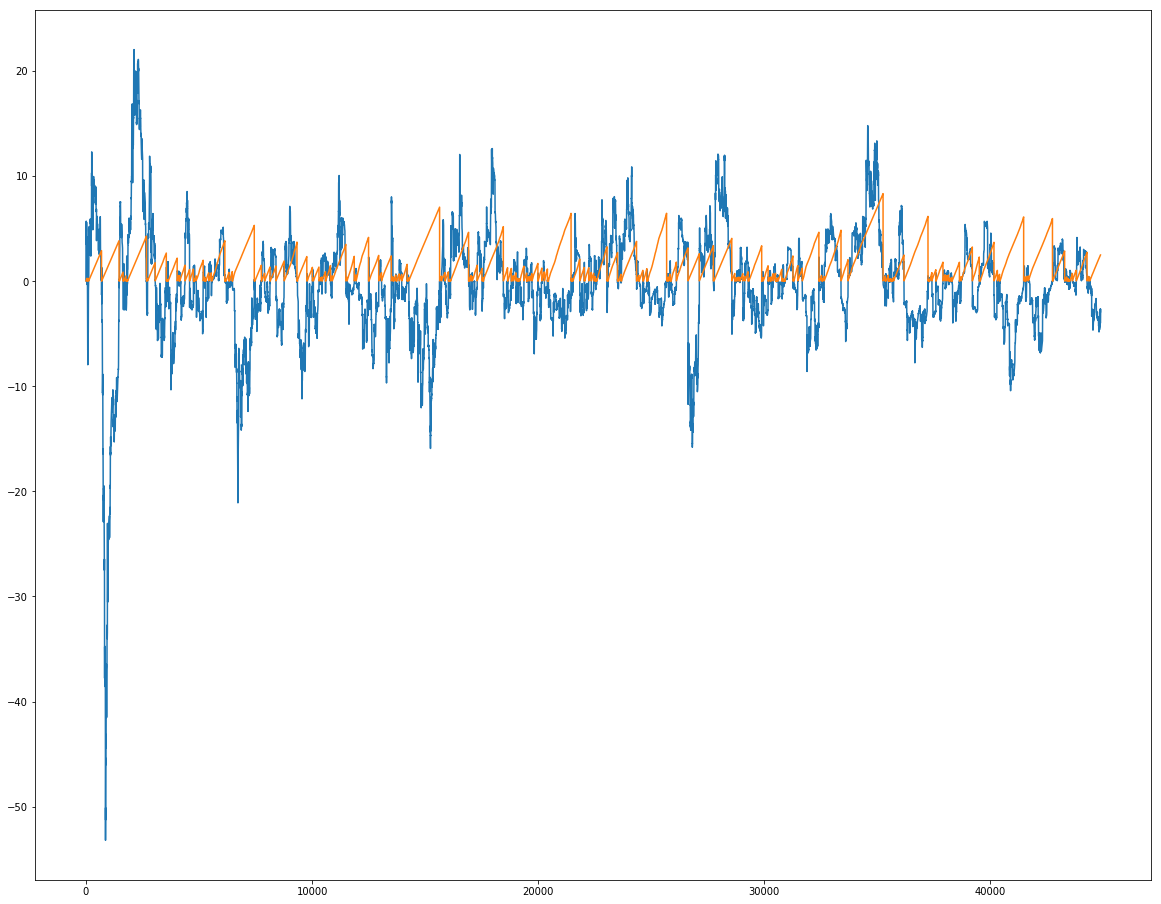

In [110]:
#visualising last cross

plt.figure(figsize=(20,16))
plt.plot(df_list[0][:,-2])
plt.plot(df_list[0][:,-1]/50)
plt.show()

In [ ]:
#calculating all results
df_path='/Users/hudsonyeo/Desktop/Python/leo/data/day/TA/results/'

final_df=pd.DataFrame()    

for i in range(len(df_list)): #for each 20 day rolling window
    if i<19:
        continue
    print(name_list[i])

    #get -19 day
    sma=df_list[i-19][:,-2].copy() #column for SMA
    time_cross=df_list[i-19][:,-1].copy()
    
    #get -18 to 0 day (19 days in total)
    for k in range((i-18),i+1): #get 20 day moving averages
        sma=np.concatenate((sma,df_list[k][:,-2].copy()))
        time_cross=np.concatenate((time_cross,df_list[k][:,-1].copy()))
        
    cat_sma=categorise_10()
    cat_sma.fit(sma) #calculate quartile thresholds for past 20 days
    
    #get categories for past 20 days
    cat_sma_20=(cat_sma.return_quartile(sma))   

    #get x,y for regression
    x_today=df_list[i][:,-2].copy().astype(float) #column for SMA     
    y_today=df_list[i][:,-3].copy().astype(float) #column for edge
    time_cross_today=df_list[i][:,-1].copy()    
    
    #removing all NA
    isnum=(~np.isnan(x_today)) & (~np.isnan(y_today))
    #get categories of today's sma  
    cat_x_today=cat_sma.return_quartile(x_today)
    
    reg_result={}
    reg_result['date']=name_list[i]
    reg_result['total_obs']=len(x_today[isnum])   
    
    for cat in range(1,21):
        #check past 20 days quartiles and filter time_cross by category
        time_cross_fit=time_cross[cat_sma_20==cat].copy()

        #simple quartile categorisation
        cat_time=categorise_simple()
        cat_time.fit(time_cross_fit)
    
        #today's sma filter
        sma_filter_today=(cat_x_today==cat)
        #today's time categories
        cat_time_today=cat_time.return_quartile(time_cross_today)


        for quartile in [1,2,3,4]:

            filtered= (isnum & sma_filter_today) #filtering NA and sma quartile
            filtered= filtered & (cat_time_today==quartile) #filtering volume
            new_y=y_today[filtered].copy()

            q='ma_cat_'+str(cat)+'_timecross_quartile'+str(quartile)+'_'
            if (len(new_y)!=0):

                reg_result[(q+'mean')]=np.mean(new_y)
                reg_result[(q+'std')]=np.std(new_y)
                reg_result[(q+'num_obs')]=len(new_y)

            else:

                reg_result[(q+'mean')]=np.nan
                reg_result[(q+'std')]=np.nan
                reg_result[(q+'num_obs')]='0'

    final_df=final_df.append(reg_result,ignore_index=True)                
temp=df_path+'result_10split_time_cross_3min_sma_mean.csv'
final_df.to_csv(temp)
print('done',temp)

In [104]:
#analysis of results
data=pd.read_csv('/Users/hudsonyeo/Desktop/Python/leo/data/day/TA/results/result_10split_time_cross_3min_sma_mean.csv')
x=[]
x_std=[]
pos=[]
num_obs=[]
for ma_cat in range(1,21):
    for vol_cat in range(1,5):
        col='ma_cat_'+str(ma_cat)+'_timecross_quartile'+str(vol_cat)+'_mean'
        std=data.loc[:,col].std()
        mean=data.loc[:,col].mean()
        column=data.loc[:,col]
        x_std.append(std)
        x.append(mean)
        percentage=len(column[column>=0])/len(column)
        pos.append(percentage)  
        
        obs='ma_cat_'+str(ma_cat)+'_timecross_quartile'+str(vol_cat)+'_num_obs'
        obs=data.loc[:,obs].sum()
        num_obs.append(obs)
x=np.asarray(x)
x=np.reshape(x,(20,4))
x_std=np.asarray(x_std)
x_std=np.reshape(x_std,(20,4))
pos=np.asarray(pos)
pos=np.reshape(pos,(20,4))
num_obs=np.asarray(num_obs)
num_obs=np.reshape(num_obs,(20,4))
print('mean\n',x)
print('std\n',x_std)
print('% positive\n',pos)
print('num obs\n',num_obs)

mean
 [[-0.10854411  0.26273985  0.17097252  0.87354952]
 [-0.18923359 -0.00685758 -0.05478326  0.31378477]
 [-0.16702692 -0.01231801 -0.06603448  0.19985703]
 [-0.19561062 -0.02439402 -0.0283319   0.05870997]
 [-0.26422817 -0.27814559 -0.12348657 -0.13357914]
 [-0.36823821 -0.18689519 -0.23138988 -0.1405827 ]
 [-0.38556752 -0.26627807 -0.11604201 -0.04108685]
 [-0.31192424 -0.18428211 -0.14920581 -0.03525649]
 [-0.20875238 -0.28063032 -0.09020736 -0.00748274]
 [-0.16096751 -0.20236623  0.00698981  0.09774131]
 [ 0.09855055  0.06962711 -0.15726689 -0.23784213]
 [ 0.24321201  0.16060546  0.07314344 -0.25631352]
 [ 0.2210432   0.25192149  0.01325307 -0.1722097 ]
 [ 0.2618518   0.09441724 -0.12205659  0.02058406]
 [ 0.27835731  0.15693841  0.13183503 -0.13240476]
 [ 0.30014834  0.1247188   0.0422738  -0.03945308]
 [ 0.29508468  0.17324779  0.20477328 -0.01377441]
 [ 0.21057485  0.25979297  0.23561226 -0.14522485]
 [ 0.26826609  0.21341779  0.38272884 -0.11859334]
 [ 0.26733933 -0.15364642